Install efficientnet for pytorch

In [1]:
!pip install efficientnet-pytorch

Import required libraries

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Extract data for use on google colab

In [ ]:
#copy data zip from drive
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/uni/Honours/ISIC_2019.zip ./data/ISIC_2019.zip

#unzip dataset
!unzip -x -q ./data/ISIC_2019.zip

#remove zip file
!rm ISIC_2019.zip

Mounted at /content/drive


Sort data into folders based on class

In [42]:
# function to sort the images into class folders based on given csv file
def copy_images_to_folders(csv_path, image_folder, output_folder):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        image_name = row['image'] + '.jpg'  # Assuming images have '.jpg' extension
        image_path = os.path.join(image_folder, image_name)

        # Iterate through class columns and copy images to the corresponding folders
        for class_name in df.columns[1:]:
            class_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)  # Create folder if it doesn't exist

            if row[class_name] == 1:  # Check if the image belongs to the class
                shutil.copy(image_path, class_folder)

csv_path = 'data/ISIC_2019_Training_GroundTruth.csv'
image_folder = 'data/ISIC_2019_Resized'
output_folder = 'data/ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)

print("done")

done


Split data into training, validation and test

In [43]:
# declare variables for model creation
input_folder = 'data/ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data/data_subset'  # The desired output folder for "training" and "validation" folders
#data_dir = '/content/data_subset'
sample_limit=None #None or a number up to 12875
train_ratio=0.6
val_ratio=0.2
test_ratio=0.2

print(train_ratio+val_ratio+test_ratio)

set_batch_size=64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

'''
Melanoma (MEL)
Melanocytic nevus (NV)
Basal cell carcinoma (BCC)
Actinic keratosis (AK)
Benign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
Dermatofibroma (DF)
Vascular lesion (VASC)
Squamous cell carcinoma (SCC)
None of the others (UNK)
'''

print("done")

1.0
done


In [44]:
# Remove existing "training" and "validation" folders if they exist
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)
shutil.rmtree(test_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

print("done")

done


In [45]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]
        
        # Limit the number of samples if sample_limit is provided
        if sample_limit is not None:
            images = images[:sample_limit]

        # Randomly shuffle the list of images
        np.random.seed(42)
        np.random.shuffle(images)

        # Calculate the number of samples for training and validation
        class_size = len(images)
        num_training_samples = int(class_size * train_ratio)
        num_val_samples = int(class_size * val_ratio)
        num_test_samples = int(class_size * test_ratio)

        # Create the class subfolders within the output folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        class_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)
        os.makedirs(class_folder_test, exist_ok=True)

        # Copy images to the training folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)
        # Copy images to the validation folder
        for image_name in images[num_training_samples:num_training_samples + num_val_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)
        # Copy images to the test folder
        for image_name in images[num_training_samples + num_val_samples:]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_test)

print("done")

done


In [46]:
#remove unknown folder as no samples
shutil.rmtree("data/data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/val/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/test/UNK", ignore_errors=True)

In [47]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [48]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#print checks to see if the values are the same - if yes then can remove the assignment here
class_names = image_datasets['train'].classes
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [9]:
def calculate_class_weights(data_dir):
    """
    Calculate class weights based on the number of samples in each class folder.
    
    Args:
    - data_dir (str): Path to the directory containing class folders.
    
    Returns:
    - class_weights (dict): Dictionary containing class weights.
    """
    # Initialize dictionary to store class samples counts
    class_samples = {}
    
    # Iterate over class folders
    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        # Count the number of files (samples) in the class folder
        num_samples = len(os.listdir(class_path))
        # Store the count in the dictionary
        class_samples[class_folder] = num_samples
    
    # Calculate total number of samples
    total_samples = sum(class_samples.values())
    
    # Calculate class frequencies
    class_frequencies = {class_label: num_samples / total_samples for class_label, num_samples in class_samples.items()}
    
    # Compute inverse class frequencies as weights
    class_weights = {class_label: 1 / frequency for class_label, frequency in class_frequencies.items()}
    
    # Normalize the weights
    total_weight = sum(class_weights.values())
    class_weights_normalized = {class_label: weight / total_weight for class_label, weight in class_weights.items()}
    
    return class_weights_normalized

# Example usage:
data_dir = "data/data_subset/train"
class_weights = calculate_class_weights(data_dir)
print("Class Weights:", class_weights)


Class Weights: {'AK': 0.09696202173991755, 'BCC': 0.02529867100088165, 'BKL': 0.03203319650874023, 'DF': 0.3525891699633365, 'MEL': 0.01858468533164656, 'NV': 0.006526893372784094, 'SCC': 0.13409641304456682, 'VASC': 0.3339089490381266}


In [ ]:
# oversample training set

# get the sample size for each class
class_sizes = [len(os.listdir(os.path.join(training_folder, class_name))) for class_name in class_names]

# get the max sample size across classes
max_class_size = max(class_sizes)

# Calculate the desired repetitions for each class
# this is the number of times a sample needs to be repeated to match the max class size
desired_repetitions = [max_class_size // class_size if class_size > 0 else 1 for class_size in class_sizes]

# Iterate through each class and oversample accordingly
for class_index, class_name in enumerate(class_names):
    #get the training folder for the current class
    class_folder_training = os.path.join(training_folder, class_name)
    class_indices = [i for i, label in enumerate(image_datasets['train'].targets) if label == class_index]

    weights = [1.0 if label != class_index else desired_repetitions[class_index] for label in image_datasets['train'].targets]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    # Update the data loader for the "training" set with the weighted sampler
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=set_batch_size, sampler=sampler, num_workers=2)

show sample images

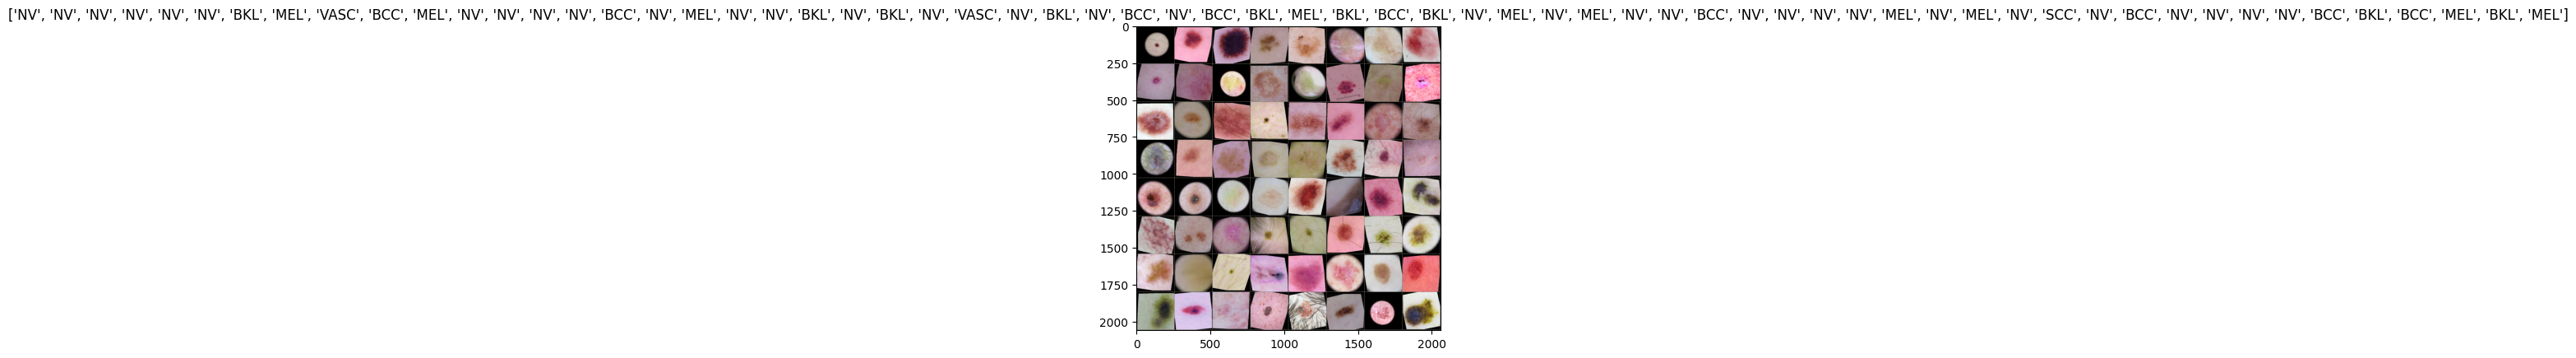

In [49]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

temporary fix for efficientnet weights issue

In [50]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [19]:
# Define a custom neural network model based on EfficientNetB0
class CustomEfficientNetB0(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.5):
        super(CustomEfficientNetB0, self).__init__()
        # Load the pre-trained EfficientNetB0 model
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
        # Get the number of input features to the final fully connected layer
        num_ftrs = self.model._fc.in_features
        # Replace the final fully connected layer with an identity layer
        self.model._fc = nn.Identity()  # remove the original fully connected layer
        # Define additional fully connected layers
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = dropout_prob
    
    def forward(self, x, dropout=True):
        # Forward pass through the EfficientNetB0 model
        x = self.model(x)
        # Pass through the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout regularization if specified
        if dropout:
            x = F.dropout(x, p=self.dropout)
        # Pass through the final fully connected layer
        x = self.fc2(x)
        return x

# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=len(class_names), dropout_prob=0.3)

# Move the model to the specified device (e.g., GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Define the loss function with class weights (cross-entropy loss)
#class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [15]:
class FocalLossMultiClass(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduction='mean'):
        super(FocalLossMultiClass, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Replacing the loss function definition with Focal Loss for multi-class classification
criterion = FocalLossMultiClass()

In [203]:
def validate_model(model, criterion, data_loader, device, num_val_mc_samples=100):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_list = [model(inputs).unsqueeze(0) for _ in range(num_val_mc_samples)]
            outputs_mean = torch.cat(outputs_list, dim=0).mean(dim=0)
            loss = criterion(outputs_mean, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs_mean, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

In [51]:
def validate_model(model, criterion, data_loader, device, num_val_mc_samples=100, num_classes=1):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_list = [model(inputs).unsqueeze(0) for _ in range(num_val_mc_samples)]
            outputs_mean = torch.cat(outputs_list, dim=0).mean(dim=0)
            
            # Normalize the loss by the number of classes
            loss = criterion(outputs_mean, labels) / num_classes
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs_mean, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

In [13]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=50, num_val_mc_samples=100, loss_weight=0.5):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f'Epoch {epoch + 1}/{num_epochs} - {current_time}')
            print('-' * 10)

            for phase in ['train', 'val']:
                model.train(phase == 'train')
                data_loader = dataloaders[phase]

                if phase == 'train':
                    running_loss = 0.0
                    running_corrects = 0
                    total_samples = 0
                    
                    for inputs, labels in data_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        _, preds = torch.max(outputs, 1)
                        running_corrects += torch.sum(preds == labels.data)
                        total_samples += labels.size(0)

                    epoch_loss = running_loss / dataset_sizes[phase]
                    epoch_acc = running_corrects.double() / total_samples
                    print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}')
                    
                    if phase == 'train':
                        train_losses.append(epoch_loss)
                        train_accuracies.append(epoch_acc)
                    
                else:
                    epoch_loss, epoch_acc = validate_model(model, criterion, data_loader, device, num_val_mc_samples)
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)
                    print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}')
                    
                    # Calculate combined metric
                    combined_metric = epoch_acc - loss_weight * epoch_loss
                    if combined_metric > best_combined_metric:
                        best_combined_metric = combined_metric
                        best_val_loss = epoch_loss
                        best_val_acc = epoch_acc
                        best_epoch = epoch + 1  # Store the epoch number
                        torch.save(model.state_dict(), best_model_params_path)

            print()

        print(f'Best combined metric: {best_combined_metric:.4f}')
        print(f'Loss associated with the best combined metric: {best_val_loss:.4f}')
        print(f'Accuracy associated with the best combined metric: {best_val_acc:.4f}')
        print(f'Epoch associated with the best model: {best_epoch}')
        model.load_state_dict(torch.load(best_model_params_path))

In [52]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=50, num_val_mc_samples=100, loss_weight=0.5, num_classes=1):
    since = time.time()

    best_combined_metric = 0.0
    best_model_weights = copy.deepcopy(model_ft.state_dict())
    best_val_loss = 0.0
    best_val_acc = 0.0
    best_epoch = 0
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f'Epoch {epoch + 1}/{num_epochs} - {current_time}')
            print('-' * 10)

            for phase in ['train', 'val']:
                model.train(phase == 'train')
                data_loader = dataloaders[phase]

                if phase == 'train':
                    running_loss = 0.0
                    running_corrects = 0
                    total_samples = 0
                    
                    for inputs, labels in data_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                        # Apply class-wise normalization
                        loss = loss / num_classes
                        
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        _, preds = torch.max(outputs, 1)
                        running_corrects += torch.sum(preds == labels.data)
                        total_samples += labels.size(0)

                    epoch_loss = running_loss / dataset_sizes[phase]
                    epoch_acc = running_corrects.double() / total_samples
                    print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}')
                    
                    if phase == 'train':
                        train_losses.append(epoch_loss)
                        train_accuracies.append(epoch_acc)
                    
                else:
                    epoch_loss, epoch_acc = validate_model(model, criterion, data_loader, device, num_val_mc_samples, num_classes)
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)
                    print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}')
                    
                    # Calculate combined metric
                    combined_metric = epoch_acc - loss_weight * epoch_loss
                    if combined_metric > best_combined_metric:
                        best_combined_metric = combined_metric
                        best_val_loss = epoch_loss
                        best_val_acc = epoch_acc
                        best_epoch = epoch + 1  # Store the epoch number
                        torch.save(model.state_dict(), best_model_params_path)

            print()

        print(f'Best combined metric: {best_combined_metric:.4f}')
        print(f'Loss associated with the best combined metric: {best_val_loss:.4f}')
        print(f'Accuracy associated with the best combined metric: {best_val_acc:.4f}')
        print(f'Epoch associated with the best model: {best_epoch}')
        model.load_state_dict(torch.load(best_model_params_path))

In [53]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_classes = len(class_names)
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=50, num_val_mc_samples=100, loss_weight=1, num_classes=num_classes)

Epoch 1/50 - 2024-03-06 10:50:48
----------
Train Loss: 0.0798, Train Acc: 0.7683


KeyboardInterrupt: 

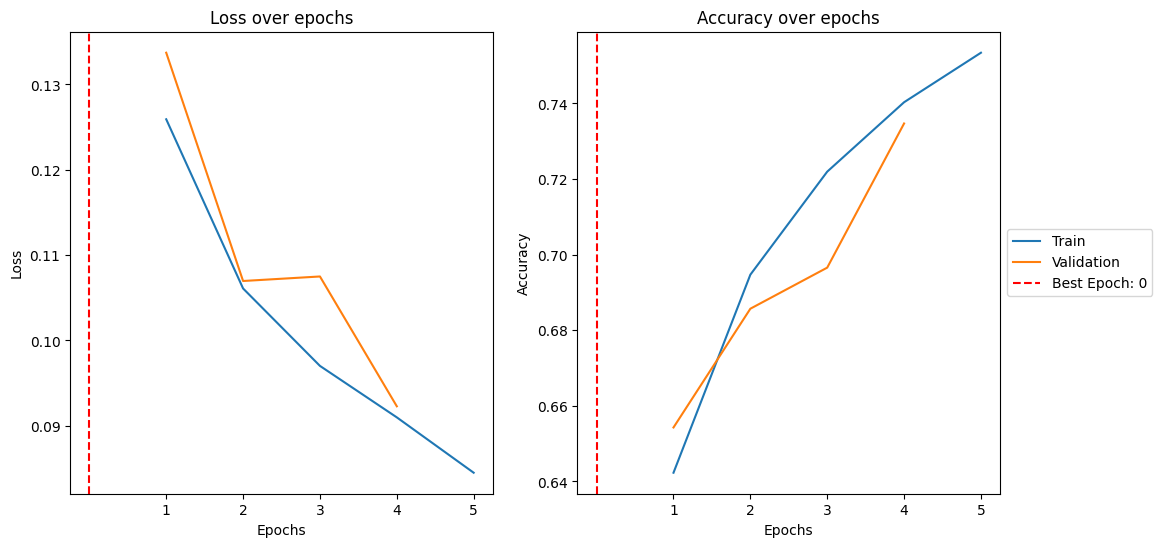

In [23]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Move accuracies to CPU
    # not needed for losses as they were never moved to GPU
    train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
    val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(train_losses)+1), train_losses, label='Train')
    plt.plot(np.arange(1, len(val_losses)+1), val_losses, label='Validation')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')  # Add vertical line at best_epoch
    plt.legend().remove()  # Remove legend from the first subplot
    plt.xticks(np.arange(1, len(train_losses)+1))  # Set x-axis ticks from 1 to the number of epochs

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(train_accuracies)+1), train_accuracies, label='Train')
    plt.plot(np.arange(1, len(val_accuracies)+1), val_accuracies, label='Validation')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Add the best epoch to the legend for the second subplot
    handles, labels = plt.gca().get_legend_handles_labels()
    best_epoch_label = f'Best Epoch: {best_epoch}'
    handles.append(plt.Line2D([], [], color='r', linestyle='--', label=best_epoch_label))
    plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(np.arange(1, len(train_accuracies)+1))  # Set x-axis ticks from 1 to the number of epochs

    plt.axvline(x=best_epoch, color='r', linestyle='--')  # Add vertical line at best_epoch

    plt.show()

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)


In [24]:
# Save the trained model
torch.save(model_ft.state_dict(), 'data/trained_model.pth')

In [14]:
#load the saved model
model_ft.load_state_dict(torch.load('data/trained_model.pth'))
#model.eval()  # Set the model to evaluation mode if needed

<All keys matched successfully>

visualise trained model

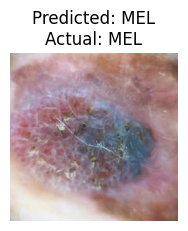

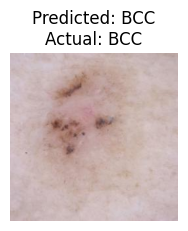

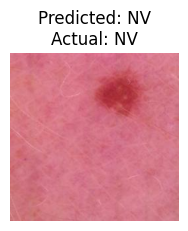

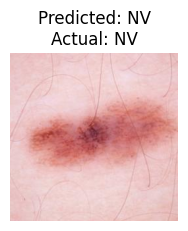

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                title = f'Predicted: {predicted_class}\nActual: {actual_class}'
                ax.set_title(title)

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft, num_images=4)

In [25]:
# get a list of risks associated with the removal of the least certain samples
def calculate_risks(guesses_are_correct, uncertainties):
    # create a blank list
    risks = []

    # while uncertainties isn't empty
    while uncertainties:
        # get risk based on average correctness/accuracy
        risk = 1 - (sum(guesses_are_correct) / len(guesses_are_correct))
        # append to list
        risks.append(risk)

        # remove results for the least certain sample
        max_uncertainty_index = uncertainties.index(max(uncertainties))
        uncertainties.pop(max_uncertainty_index)
        guesses_are_correct.pop(max_uncertainty_index)

    risks.reverse()

    return risks

print("done")

done


In [26]:
def process_labels(sample_labels, guesses_are_correct, uncertainties, class_names):
    guesses_are_correct_by_class = [[] for _ in range(len(class_names))]
    uncertainties_by_class = [[] for _ in range(len(class_names))]

    for label, correct_guess, uncertainty in zip(sample_labels, guesses_are_correct, uncertainties):
        guesses_are_correct_by_class[label].append(correct_guess)
        uncertainties_by_class[label].append(uncertainty)

    return guesses_are_correct_by_class, uncertainties_by_class

def calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, labels):
    risks = calculate_risks(guesses_are_correct, uncertainties)
    risks_list.append(risks)
    labels_list.append(labels)

def calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, labels):
    for i in range(len(class_names)):
        risks = calculate_risks(guesses_are_correct_by_class[i], uncertainties_by_class[i])
        risks_list_by_class[i].append(risks)
        labels_list_by_class[i].append(labels)

In [27]:
# Lists to store results
risks_list = []
labels_list = []

risks_list_by_class = [[] for _ in range(len(class_names))]
labels_list_by_class = [[] for _ in range(len(class_names))]

print("done")

done


In [28]:
def calculate_softmax_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            #get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # get the outputs
            outputs = model(inputs, dropout=False)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on softmax probabilities
            for idx in range(len(predicted)):
                predicted_class = predicted[idx].item()
                uncertainty = 1.0 - probabilities[idx, predicted_class].item()  # Using confidence as uncertainty
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_softmax_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Softmax Response")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Softmax Response")

print("done")

done


In [29]:
def calculate_top2_softmax_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # For every batch in the dataloader
        for inputs, labels in dataloader:
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # Get the outputs
            outputs = model(inputs, dropout=False)
            # Get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # Get the top two softmax values and their indices
            top2_probs, top2_indices = torch.topk(probabilities, k=2, dim=1)

            # Get the difference between the top two softmax values
            top2_diff = top2_probs[:, 0] - top2_probs[:, 1]

            # Get the class predictions
            _, predicted = torch.max(outputs, 1)
            # Check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Store the uncertainty as the difference between the top two softmax values
            uncertainties.extend(-top2_diff.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_top2_softmax_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Top2 Softmax Difference")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Top2 Softmax Difference")

print("Done")

Done


In [30]:
def calculate_random_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            outputs = model(inputs, dropout=False)
            _, predicted = torch.max(outputs, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Generate a single random uncertainty value for each predicted class
            for idx in range(len(predicted)):
                uncertainty = random.random()
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_random_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Random Uncertainties")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Random Uncertainties")

print("Done")

Done


In [132]:
def calculate_mc_dropout_uncertainties_by_sample(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            mean_predictions = torch.zeros(num_samples, inputs.size(0), len(class_names)).to(device)

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                outputs = model(inputs)
                predictions = F.softmax(outputs, dim=1)
                mean_predictions[i] = predictions

            # Calculate mean prediction across samples
            mean_prediction = torch.mean(mean_predictions, dim=0)

            # Calculate uncertainty using mean prediction
            uncertainties.extend(1.0 - torch.max(mean_prediction, dim=1)[0].cpu().numpy())

            # Determine correctness of predictions
            _, predicted = torch.max(mean_prediction, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_mc_dropout_uncertainties_by_sample(model_ft, dataloaders['test'], class_names, device, num_samples=100)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "MCD By Sample")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "MCD By Sample")

print("Done")

2024-03-06 06:22:26.302989 - Batch 1/80 processed
2024-03-06 06:22:27.411844 - Batch 2/80 processed
2024-03-06 06:22:28.519698 - Batch 3/80 processed
2024-03-06 06:22:29.628913 - Batch 4/80 processed
2024-03-06 06:22:30.747809 - Batch 5/80 processed
2024-03-06 06:22:31.858941 - Batch 6/80 processed
2024-03-06 06:22:32.997149 - Batch 7/80 processed
2024-03-06 06:22:34.125188 - Batch 8/80 processed
2024-03-06 06:22:35.248813 - Batch 9/80 processed
2024-03-06 06:22:36.370314 - Batch 10/80 processed
2024-03-06 06:22:37.479746 - Batch 11/80 processed
2024-03-06 06:22:38.586819 - Batch 12/80 processed
2024-03-06 06:22:39.694392 - Batch 13/80 processed
2024-03-06 06:22:40.802179 - Batch 14/80 processed
2024-03-06 06:22:41.910234 - Batch 15/80 processed
2024-03-06 06:22:43.018627 - Batch 16/80 processed
2024-03-06 06:22:44.130591 - Batch 17/80 processed
2024-03-06 06:22:45.243159 - Batch 18/80 processed
2024-03-06 06:22:46.353608 - Batch 19/80 processed
2024-03-06 06:22:47.465658 - Batch 20/80

In [133]:
def calculate_mc_dropout_uncertainties_by_class(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            logits_list = []  # Initialize a list to store logits for each sample

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                outputs = model(inputs)
                logits_list.append(outputs)  # Store logits for each sample

            # Concatenate logits along a new dimension to create a tensor
            logits_tensor = torch.stack(logits_list, dim=0)

            # Calculate average output across all samples for each class
            class_avg_outputs = torch.mean(logits_tensor, dim=0)

            # Make prediction based on class with highest average output
            _, predicted = torch.max(class_avg_outputs, 1)

            # Calculate uncertainty using the highest average output
            uncertainties.extend(1.0 - torch.max(class_avg_outputs, dim=1)[0].cpu().numpy())

            # Determine correctness of predictions
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_mc_dropout_uncertainties_by_class(model_ft, dataloaders['test'], class_names, device, num_samples=100)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "MCD By Class")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "MCD By Class")

print("Done")

2024-03-06 06:24:00.687026 - Batch 1/80 processed
2024-03-06 06:24:01.820865 - Batch 2/80 processed
2024-03-06 06:24:02.959144 - Batch 3/80 processed
2024-03-06 06:24:04.105719 - Batch 4/80 processed
2024-03-06 06:24:05.232697 - Batch 5/80 processed
2024-03-06 06:24:06.347286 - Batch 6/80 processed
2024-03-06 06:24:07.460506 - Batch 7/80 processed
2024-03-06 06:24:08.571834 - Batch 8/80 processed
2024-03-06 06:24:09.683140 - Batch 9/80 processed
2024-03-06 06:24:10.813827 - Batch 10/80 processed
2024-03-06 06:24:11.936500 - Batch 11/80 processed
2024-03-06 06:24:13.049591 - Batch 12/80 processed
2024-03-06 06:24:14.164542 - Batch 13/80 processed
2024-03-06 06:24:15.281839 - Batch 14/80 processed
2024-03-06 06:24:16.396933 - Batch 15/80 processed
2024-03-06 06:24:17.512939 - Batch 16/80 processed
2024-03-06 06:24:18.622946 - Batch 17/80 processed
2024-03-06 06:24:19.734327 - Batch 18/80 processed
2024-03-06 06:24:20.850736 - Batch 19/80 processed
2024-03-06 06:24:21.962826 - Batch 20/80

In [31]:
def calculate_variance_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            # get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # get the outputs
            outputs = model(inputs, dropout=False)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on variance over classes
            variance = torch.var(probabilities, dim=1)
            uncertainties.extend(-variance.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_variance_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Variance")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Variance")

print("Done")

Done


In [32]:
def calculate_variational_ratio_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            # get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # get the outputs
            outputs = model(inputs, dropout=False)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on Variational Ratios
            mode_probabilities, _ = torch.max(probabilities, dim=1, keepdim=True)
            other_probabilities = probabilities.clone()
            other_probabilities.scatter_(1, predicted.view(-1, 1), 0)  # Set mode probabilities to 0
            max_other_probabilities, _ = torch.max(other_probabilities, dim=1, keepdim=True)
            variational_ratio = 1.0 - mode_probabilities / max_other_probabilities
            uncertainties.extend(variational_ratio.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_variational_ratio_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Variational Ratio")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Variational Ratio")

print("Done")

Done


In [33]:
def calculate_entropy_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            # get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # get the outputs
            outputs = model(inputs, dropout=True)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on predictive entropy
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)  # Adding a small value to avoid log(0)
            uncertainties.extend(entropy.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_entropy_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Entropy")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Entropy")

print("Done")

Done


In [137]:
def calculate_predictive_entropy_uncertainties(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            entropy_list = []  # Initialize a list to store entropy for each sample

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                outputs = model(inputs, dropout=True)
                probabilities = F.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)  # Adding a small value to avoid log(0)
                entropy_list.append(entropy)  # Store entropy for each sample

            # Concatenate entropies along a new dimension to create a tensor
            entropy_tensor = torch.stack(entropy_list, dim=0)

            # Calculate average entropy across all samples
            avg_entropy = torch.mean(entropy_tensor, dim=0)

            uncertainties.extend(avg_entropy.cpu().numpy())

            # Get the class predictions based on the maximum probability
            _, predicted = torch.max(outputs, 1)

            # Determine correctness of predictions
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_predictive_entropy_uncertainties(model_ft, dataloaders['test'], class_names, device, num_samples=100)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Predictive Entropy")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Predictive Entropy")

print("Done")

2024-03-06 06:26:29.031914 - Batch 1/80 processed
2024-03-06 06:26:30.169800 - Batch 2/80 processed
2024-03-06 06:26:31.284121 - Batch 3/80 processed
2024-03-06 06:26:32.414946 - Batch 4/80 processed
2024-03-06 06:26:33.566918 - Batch 5/80 processed
2024-03-06 06:26:34.695200 - Batch 6/80 processed
2024-03-06 06:26:35.807013 - Batch 7/80 processed
2024-03-06 06:26:36.920576 - Batch 8/80 processed
2024-03-06 06:26:38.033231 - Batch 9/80 processed
2024-03-06 06:26:39.148924 - Batch 10/80 processed
2024-03-06 06:26:40.275139 - Batch 11/80 processed
2024-03-06 06:26:41.384999 - Batch 12/80 processed
2024-03-06 06:26:42.511986 - Batch 13/80 processed
2024-03-06 06:26:43.623645 - Batch 14/80 processed
2024-03-06 06:26:44.733550 - Batch 15/80 processed
2024-03-06 06:26:45.842711 - Batch 16/80 processed
2024-03-06 06:26:46.950451 - Batch 17/80 processed
2024-03-06 06:26:48.065050 - Batch 18/80 processed
2024-03-06 06:26:49.217876 - Batch 19/80 processed
2024-03-06 06:26:50.366950 - Batch 20/80

In [34]:
def calculate_mutual_information_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            # get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # get the outputs
            outputs = model(inputs, dropout=True)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on mutual information
            uniform_distribution = torch.full_like(probabilities, 1.0 / probabilities.size(1))
            mutual_information = F.kl_div(probabilities.log(), uniform_distribution, reduction='none').sum(dim=1)
            uncertainties.extend(-mutual_information.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

guesses_are_correct, uncertainties, sample_labels = calculate_mutual_information_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Mutual Information")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Mutual Information")

print("Done")

Done


In [35]:
def smooth_calcs(risks):
    # Interpolate the data for smoother curves
    x_values = np.arange(len(risks))
    total_steps = len(x_values)
    
    # Convert x-values to percentage
    x_smooth_percentage = (x_values / total_steps)  # Already between 0 and 1
    
    # Create a smooth range for the x-axis
    x_smooth_percentage_interp = np.linspace(x_smooth_percentage.min(), x_smooth_percentage.max(), 300)

    return x_smooth_percentage_interp, x_smooth_percentage

In [36]:
def calculate_aurc(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage):
    aucr_cutoff_list = []  # For 20% cutoff
    aucr_full_list = []    # For the entire curve
    
    for risks, label in zip(risks_list, labels_list):
        risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, risks)
        
        # Find indices corresponding to values less than or equal to 20% coverage
        cutoff_index = np.argmax(x_smooth_percentage_interp >= 0.2)  # 20% coverage in normalized scale

        # Calculate area under the curve from 100% coverage to the 20% cutoff
        area_cutoff = np.trapz(risks_smooth[cutoff_index:], x=x_smooth_percentage_interp[cutoff_index:])
        aucr_cutoff_list.append((label, area_cutoff))

        # Calculate area under the entire curve
        area_full = np.trapz(risks_smooth, x=x_smooth_percentage_interp)
        aucr_full_list.append((label, area_full))

    # Sort the lists based on AURC values
    aucr_cutoff_list.sort(key=lambda x: x[1])  # Sorting based on AURC for 20% cutoff
    aucr_full_list.sort(key=lambda x: x[1])    # Sorting based on AURC for the entire curve

    # Print the AURC values side by side
    max_label_length = max(len(item[0]) for item in aucr_cutoff_list + aucr_full_list)
    
    print("Label" + " " * (max_label_length - 5) + "\tAURC (20% cutoff)" + "\t" + "AURC (full)")
    print("-" * (max_label_length + 35))
    
    for cutoff_item, full_item in zip(aucr_cutoff_list, aucr_full_list):
        label_cutoff, aucr_cutoff = cutoff_item
        label_full, aucr_full = full_item
        print(f"{label_cutoff}" + " " * (max_label_length - len(label_cutoff) + 5) + f"\t{aucr_cutoff:.4f}\t\t\t{aucr_full:.4f}")

In [37]:
def plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage):
    max_risk_100_coverage = 0  # Initialize max risk value at 100% coverage

    for risks, label in zip(risks_list, labels_list):
        risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, risks)
        plt.plot(x_smooth_percentage_interp, risks_smooth, label=label, linewidth=1)
        
        # Update max risk value at 100% coverage if necessary
        max_risk_100_coverage = max(max_risk_100_coverage, risks_smooth[-1])

    # x-axis label with a percentage
    plt.xlabel('Coverage')
    plt.ylabel('Risk')
    plt.title('Risk vs. Coverage')

    # Add a vertical line at approximately 20% coverage
    plt.axvline(x=0.2, color='red', linestyle='--', label='20% Coverage')

    # Adjust the x-axis limits to range from 0 to 1
    plt.xlim(0, 1)

    # Adjust the y-axis limits
    plt.ylim(0, max_risk_100_coverage * 1.1)  # Set the upper limit slightly higher than the maximum risk at 100% coverage

    # Show legend
    plt.legend()

    plt.show()

In [38]:
description_list = [
    "Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.",
    "Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities",
    "Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.",
    "MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.",
    "MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.",
    "Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.",
    "Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.",
    "Entropy calculates uncertainty by measuring the entropy of softmax probabilities for each prediction.",
    "Predictive Entropy estimates uncertainty by averaging the entropy of softmax probabilities across multiple samples generated with dropout.",
    "Mutual Information computes uncertainty by measuring the mutual information between the model's softmax probabilities and a uniform distribution."
]

for description in description_list:
    print(f"- {description}")

print()

print("- Risk = 1 - Accuracy, where Accuracy is the mean accuracy (normalised) over the samples included in the Coverage.")
print("- Coverage is the normalised number of samples over the total samples. Coverage decreases as the most uncertain samples are removed.")
print("- Area Under Risk Coverage (AURC) is the area under the Risk Coverage curve.")

- Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.
- Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities
- Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.
- MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.
- MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.
- Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.
- Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.
- Entropy calculates unc

All Classes: 5074 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Softmax Response            	0.0935			0.0942
Variance                    	0.0936			0.0943
Top2 Softmax Difference     	0.0942			0.0949
Variational Ratio           	0.0952			0.0958
Entropy                     	0.0958			0.0965
Mutual Information          	0.1099			0.1110
Random Uncertainties        	0.2064			0.2503


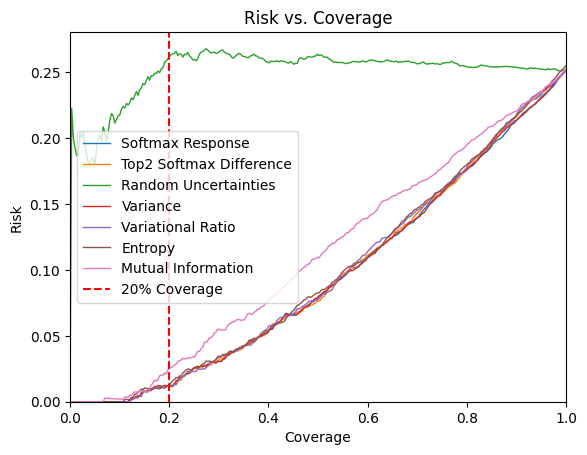

AK: 174 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Mutual Information          	0.4309			0.5348
Entropy                     	0.4467			0.5762
Variance                    	0.4631			0.5920
Random Uncertainties        	0.4711			0.5925
Softmax Response            	0.4772			0.6053
Top2 Softmax Difference     	0.4966			0.6223
Variational Ratio           	0.5019			0.6330


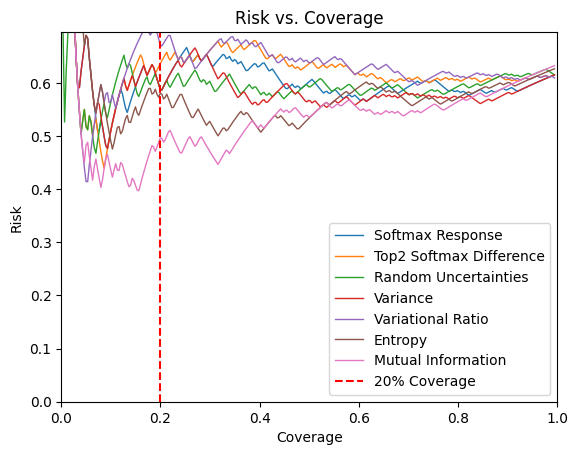


BCC: 666 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Variational Ratio           	0.1088			0.1323
Top2 Softmax Difference     	0.1089			0.1339
Softmax Response            	0.1108			0.1372
Variance                    	0.1151			0.1415
Entropy                     	0.1233			0.1480
Mutual Information          	0.1629			0.2189
Random Uncertainties        	0.2066			0.2410


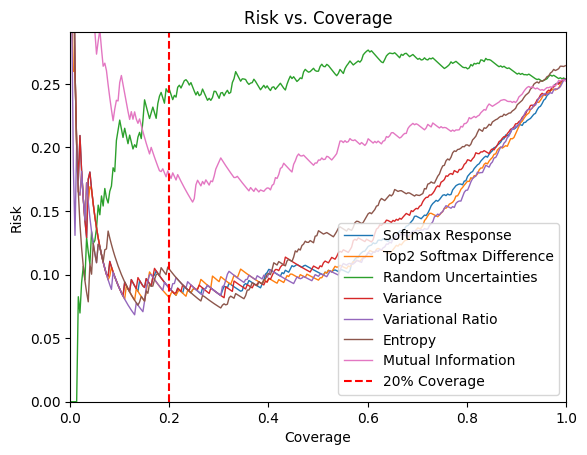


BKL: 526 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Variational Ratio           	0.2135			0.2416
Top2 Softmax Difference     	0.2146			0.2471
Softmax Response            	0.2174			0.2525
Variance                    	0.2196			0.2548
Entropy                     	0.2276			0.2686
Mutual Information          	0.2577			0.3101
Random Uncertainties        	0.3104			0.3909


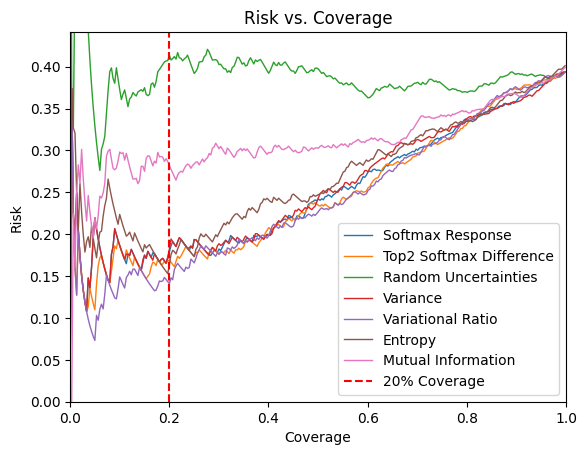


DF: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Entropy                     	0.2235			0.2235
Variance                    	0.2453			0.2453
Mutual Information          	0.2466			0.2511
Softmax Response            	0.2511			0.2572
Top2 Softmax Difference     	0.2592			0.2592
Variational Ratio           	0.2598			0.2598
Random Uncertainties        	0.3667			0.4317


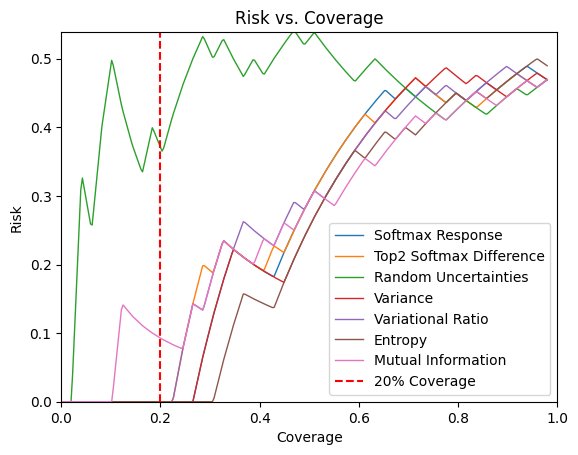


MEL: 905 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Variational Ratio           	0.2630			0.2794
Variance                    	0.2644			0.2820
Top2 Softmax Difference     	0.2646			0.2828
Softmax Response            	0.2651			0.2834
Entropy                     	0.2675			0.2877
Mutual Information          	0.2716			0.2961
Random Uncertainties        	0.3602			0.4470


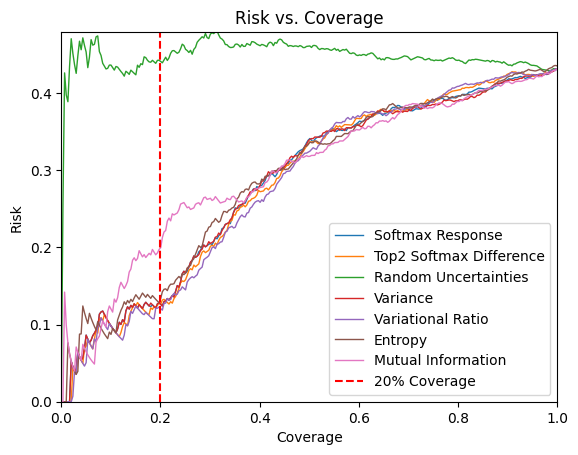


NV: 2575 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Variance                    	0.0181			0.0181
Softmax Response            	0.0182			0.0182
Entropy                     	0.0183			0.0183
Top2 Softmax Difference     	0.0190			0.0190
Variational Ratio           	0.0200			0.0200
Mutual Information          	0.0225			0.0225
Random Uncertainties        	0.0825			0.0981


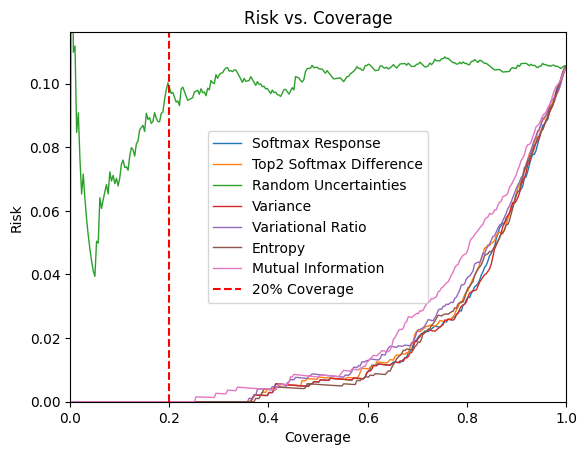


SCC: 127 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Mutual Information          	0.5250			0.6816
Variational Ratio           	0.5502			0.7029
Top2 Softmax Difference     	0.5538			0.7045
Entropy                     	0.5573			0.7088
Softmax Response            	0.5581			0.7107
Variance                    	0.5600			0.7133
Random Uncertainties        	0.5797			0.7226


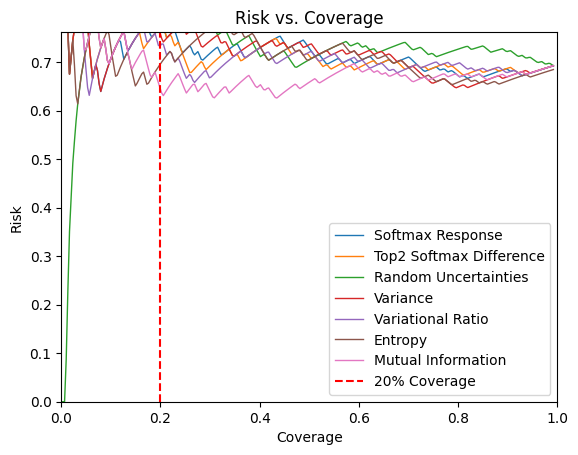


VASC: 52 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Variance                    	0.1747			0.1782
Softmax Response            	0.1750			0.1785
Top2 Softmax Difference     	0.1809			0.1825
Variational Ratio           	0.1900			0.1918
Mutual Information          	0.2023			0.2023
Entropy                     	0.2026			0.2043
Random Uncertainties        	0.3628			0.4532


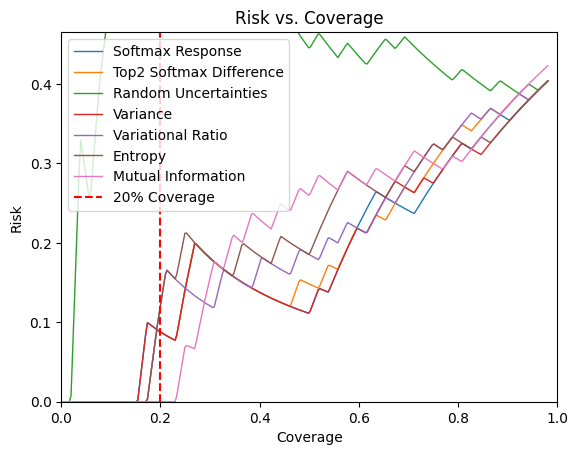


done


In [39]:
print(f"All Classes: {len(risks_list[0])} samples")
x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(risks_list[0])
calculate_aurc(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)
# Plot the risk coverage curve
plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)

for i in range(len(class_names)):
    print(f"{class_names[i]}: {len(risks_list_by_class[i][0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(risks_list_by_class[i][0])
    calculate_aurc(risks_list_by_class[i], labels_list_by_class[i], x_smooth_percentage_interp, x_smooth_percentage)
    # Plot the risk coverage curve
    plot_risk_coverage(risks_list_by_class[i], labels_list_by_class[i], x_smooth_percentage_interp, x_smooth_percentage)
    print()
    
print("done")